# This notebook will explore gene set enrichment of in stages and clusters

## Imports

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import scvelo as scv
from scipy import stats
import os
import matplotlib
import pickle
%matplotlib inline
import palantir
import harmony
import random
np.random.seed(0)
random.seed(0)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


## Settings

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()


## Loading individual datasets

In [5]:
def save_intermediate_files(datasets, temp_dir, file_name_template, identifier):
    for d in datasets:
        file = os.path.join('.', temp_dir, file_name_template + '_' + d.obs[identifier][0] + '.h5ad')
        d.write(file, compression='gzip')
        
identifiers = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27']
      
def load_intermediate_files(temp_dir, file_name_template, identifiers):
    ob_list = []
    for i in identifiers:
        file = os.path.join('.', temp_dir, file_name_template + '_' + i+ '.h5ad')
        ob_list.append(sc.read_h5ad(file))
    return ob_list

In [6]:
import sys
sys.path.append('../Integrated_analysis/')
from Integrate import concat_for_harmony, adata_to_df

In [8]:
#loading and concatenating files
stages = ['st08', 'st10.5', 'st12', 'st13', 'st16', 'st18', 'st20', 'st22', 'st24', 'st27']
adatas = load_intermediate_files( '../intermediate_files', 'zUMI_raw_singlets' , stages)



In [9]:
counts = concat_for_harmony(adatas, stages)
norm_df = harmony.utils.normalize_counts(counts)
hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=2000)
data_df = harmony.utils.log_transform(norm_df.loc[:,hvg_genes])


st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27
Concatenating data..


In [8]:
#pd.Series(data_df.columns).to_csv('Sup_tables/hvgs.tsv', sep = '\t', index = False)

In [9]:
#counts.T.to_csv('intermediate_files/Xen_raw_counts.tsv', sep = '\t')

In [10]:
def adata_hvg(adata, N_genes = 1000):
    print(adata.obs.stage[0])
    counts = pd.DataFrame(data = adata.X.todense(), 
                          index = adata.obs_names,
                          columns = adata.var_names)
    norm_df = harmony.utils.normalize_counts(counts)
    hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=N_genes)
    return hvg_genes.tolist()

In [11]:
def flatten(ls):
    return [x for y in ls for x in y]
hvg_genes_per_data = list(set(flatten([adata_hvg(x, N_genes = 500) for x in adatas])))

st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27


In [12]:
len(hvg_genes_per_data)

3906

In [13]:
#Cell type colors from integrated annotation
colors = [
[(0.3388235294117647, 0.7117262591311034, 0.40584390618992694),0, 2],
[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),1, 4],
[(0.5573241061130334, 0.8164244521337947, 0.546958861976163),2, 3],
[(0.7364705882352941, 0.08, 0.10117647058823528),3, 9],
[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778),4, 1],
[(0.8828143021914648, 0.9546943483275664, 0.8621914648212226),5, 5],
[(0.9466666666666667, 0.26823529411764707, 0.19607843137254902),6, 8],
[(0.586082276047674, 0.586082276047674, 0.586082276047674),7, 0],
[(0.996078431372549, 0.8091503267973856, 0.39607843137254906),8, 14],
[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897),9, 10],
[(0.41708573625528644, 0.6806305267204922, 0.8382314494425221),10, 11],
[(0.5513264129181085, 0.537916186082276, 0.7524490580545944),11, 13],
[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),12, 7],
[(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),13, 12],
[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),14, 6]]
colors = pd.DataFrame(colors, columns = ['color', 'org_clust', 'clust_order'])

In [14]:
%matplotlib inline

In [15]:
#Setting up stage and cluster annotation

In [16]:
tp = pd.Series(index=data_df.index)
for t in stages:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t

In [17]:
import pickle
with open('../intermediate_files/clusters', "rb") as f:
    clusters = pickle.load( f)

In [32]:
#Remove non-informative gene names
#data = data_df.copy()
# for all genes


data = norm_df.loc[:,hvg_genes_per_data]
genes_sub = [x for x in data.columns if 'LOC' not in x]
genes_sub = [x for x in genes_sub if 'Xetrov' not in x]
genes_sub = [x for x in genes_sub if 'Xelaev' not in x]
genes_sub = [x for x in genes_sub if 'MGC' not in x]
genes_sub = [x for x in genes_sub if '|loc' not in x]
print('Subsetting to {} genes'.format(len(genes_sub)))
data = data.loc[:,genes_sub]

Subsetting to 2979 genes


In [33]:
#data.to_csv('Sup_tables/hvgs.tsv', sep = '\t')

In [34]:
#Load affinity matrix
with open('../intermediate_files/aug_aff', "rb") as f:
    aug_aff = pickle.load( f)

In [35]:
#Diffusion maps for palantir
dm_res = palantir.utils.run_diffusion_maps(aug_aff,n_components=20,
    knn=20)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = data_df.index

In [36]:
#Magic imputation
imp_df = palantir.utils.run_magic_imputation(norm_df, dm_res)

In [37]:
#Search by gene id
def find(gene):
    return list(imp_df.columns[imp_df.columns.str.match(r'^(gene[0-9]+\|){}'.format(gene))])

## Dotplots of marker genes

In [20]:
data = norm_df.copy()
data['Clusters'] = clusters
means = data.groupby('Clusters').mean()
per = data.groupby('Clusters').apply(lambda x: (x != 0).sum(axis = 0).div(x.shape[0])) * 100

In [22]:
genes = ['gene94|pou5f3.2.L','gene13271|sox3.S','gene15250|eef1a1o.L', 'gene5617|tubb4b.L', 'gene13635|atp6v1g3.S', 'gene42537|otog.L', 'gene13442|pfn1.L', 
        'gene12224|hist1h2aa.L', 'gene10103|hmgb3.L', 'gene8397|ccnb1.2.L', 'gene1566|hmgn1.L','gene4142|cirbp.L', 'gene8127|nsep1', 'gene555|tmsb4x.L', 'gene51016|tpm4.S', 'gene45756|cav-3', 'gene13938|wdr60.L','gene7961|pcm1.L', 'gene4819|ca2.L', 'gene20453|atp6a1', 'gene18434|cox7a2.S', 'gene16436|itln1.L', 'gene16544|camk2g.L', 
        'gene15272|anp32c.S', 'gene4112|bmp7.2.L', 'gene13271|sox3.S', 'gene7291|gmnn.S', 'gene12364|has1.S', 'gene8191|prmt1.S', 'gene11052|ncl.S', 'gene10681|h2afz.L', 'gene18928|epcam.L', 'gene15250|eef1a1o.L', 'gene2543|sec61b.L', 'gene8876|bsg.L', 'gene1670|pcdh8.2.L', 'gene961|gpx3.S', 'gene37785|ano1.L', 'gene14901|kcna4.S', 'gene15879|ctbs.S', 'gene13442|pfn1.L', 'gene2352|foxa1.L', 'gene4519|ccno.S', 'gene12208|arl2bp.L', 'gene5854|tekt2.S', 'gene16696|cfap45.S', 'gene5681|dynlrb2.L', 'gene1994|stmnd1.S', 'gene8777|txn.L', 'gene18434|cox7a2.S', 'gene16436|itln1.L', 'gene15239|fucolectin.S']



In [23]:
from scipy.stats import zscore
means = pd.DataFrame(zscore(means), index = means.index, columns = means.columns)[genes]

In [24]:

melt = pd.melt(means[genes].reset_index(),  id_vars = ['Clusters'])
melt2 = pd.melt(per[genes].reset_index(),  id_vars = ['Clusters'])
melt.columns = ['x', 'y', 'value']
melt2.columns = ['x', 'y', 'size']
melt['size'] = melt2['size']

In [25]:
order = colors.sort_values('clust_order').org_clust.tolist()

In [26]:
binar = means[genes].T.apply(np.argmax, axis = 1)
binar = pd.crosstab(binar.index, binar.values)
binar[6] = 0
row_order = binar.sort_values(order, ascending = False).index

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


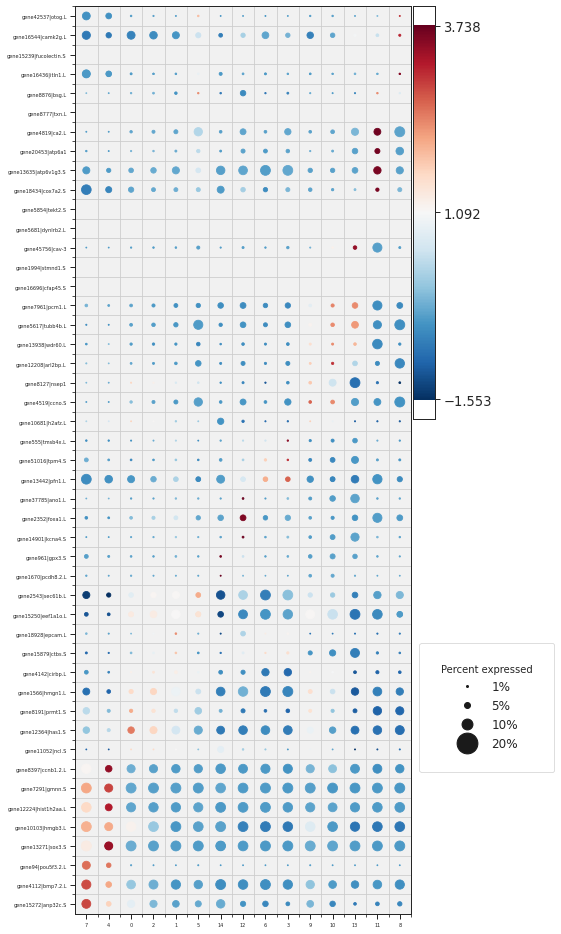

In [28]:
import seaborn as sns


## Function to make a dotplot 
# Source: https://www.kaggle.com/drazen/heatmap-with-sized-markers
#           and https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
def heatmap(x, y, size_legend = False, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors)

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs:
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs:
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}
    plt.figure(figsize=(10, 20))
    plot_grid = plt.GridSpec(2, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size],
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    if size_legend:
        axl = plt.subplot(plot_grid[1:,-1]) 
        axl.axis("off")

        l1, = plt.plot([],[], 'or', markersize=value_to_size(1), c = 'k')
        l2, = plt.plot([],[], 'or', markersize=value_to_size(5), c = 'k')
        l3, = plt.plot([],[], 'or', markersize=value_to_size(10), c = 'k')
        l4, = plt.plot([],[], 'or', markersize=value_to_size(20), c = 'k')


        labels = ['1%', '5%', '10%', '20%']

        leg = axl.legend([l1, l2, l3, l4], labels, ncol=1, frameon=True, fontsize=12,
        handlelength=2, loc = 6, borderpad = 1.8,
        handletextpad=1, title='Percent expressed', scatterpoints = 1)

    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], #rotation=90,
    horizontalalignment='center',
    fontdict={'fontsize':5})
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num], fontdict={'fontsize':5})

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:1,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right
        plt.subplots_adjust(left=0.40, bottom=0.25, right=None, top=None, wspace=None, hspace=None)
    

#Make dotplot / heatmap of the quantification
heatmap(
    y = melt['y'], x = melt['x'],
    color=melt['value'],
    size_legend = True,
    palette=sns.color_palette("RdBu_r", 256) ,
    #size=melt['value'].abs(),
    marker = 'o',
    size = melt['size'],
    x_order=colors.sort_values('clust_order').org_clust,
    y_order=row_order,
    size_scale=100)
plt.savefig('figures/markers_dotplot_p_expressed.pdf')
#plt.subtitle('Reactome Therm Counts')

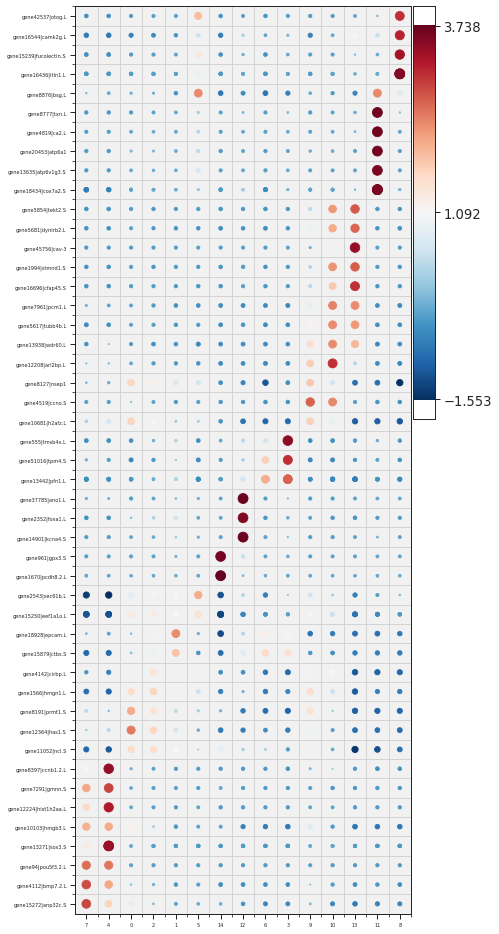

In [29]:
heatmap(
    y = melt['y'], x = melt['x'],
    color=melt['value'],
    palette=sns.color_palette("RdBu_r", 256) ,
    size=melt['value'].abs(),
    marker = 'o',
    #size = melt['size'],
    x_order=colors.sort_values('clust_order').org_clust,
    y_order=row_order,
    size_scale=100)
plt.savefig('figures/markers_dotplot.pdf')